#[1] Mount Google Drive

In [165]:
import os
import sys
# Set Path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#[2] Setting up Environment and Install Requirements

In [166]:
path_wd = '/content/drive/MyDrive/Github/Content'
os.chdir(path_wd)

!pip install -r sources/ChinaFilm/requirements.txt
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

import pandas as pd
import numpy as np
import datetime as dt
import re
import random
import jieba.analyse
tfidf = jieba.analyse.extract_tags
textrank = jieba.analyse.textrank

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

# [3] Load Release and Registration Records

In [167]:
# ImportImport Releases
path_releases = '/content/drive/MyDrive/Github/Content/sources/ChinaFilm/records/contents_of_releases.csv'
df_releases = pd.read_csv(path_releases, index_col=0, encoding='utf-8')

# Import Reg
path_regs = '/content/drive/MyDrive/Github/Content/sources/ChinaFilm/records/contents_of_registrations.csv'
df_reg = pd.read_csv(path_regs, index_col=0, encoding='utf-8')
df_reg['匹配片名'] = df_reg['片名']


# Get Latest Issue
str_date_curr_release = df_releases.sort_values(by='公示日期', ascending=False).iloc[0]['公示日期']
dt_curr_release = dt.datetime.strptime(str_date_curr_release, '%Y-%m-%d')
df_curr_releases = df_releases[df_releases['公示日期']==str_date_curr_release]
df_curr_releases = df_curr_releases[['电影类别', '编码', '公映证号', '片名', '第一出品单位']].copy()

In [168]:
# Check for unmatched records and perform mannual matches
df_matched = df_reg[df_reg['匹配片名'].isin(df_curr_releases['片名'].to_numpy())]
df_curr_releases.loc[~df_curr_releases['片名'].isin(df_matched['片名'].to_numpy())]

,电影类别,编码,公映证号,片名,第一出品单位
序号,,,,,
2,国产故事片,1100312021,32,如歌少年,浙江思成影业有限公司
4,国产故事片,1100452021,44,永春拳之黄金蝴蝶刀,广东镇宇影视传媒有限公司
9,国产故事片,1100782021,69,射雕英雄传之九阴白骨瓜,北京拉近影业有限公司
13,国产故事片,1101292021,120,毒影迷踪,陕西新弘晟晖影视制作发行有限公司
14,国产故事片,1101302021,121,伊水栾山,河南电影电视制作集团有限公司
16,国产故事片,1101722021,150,谢谢你温暖我的世界,河南日报报业集团有限公司
18,国产故事片,1101782021,161,澳门十月,伟雄文化传媒（佛山）有限公司
20,国产故事片,1102122021,186,超越,上海猎豹文化传媒有限公司
21,国产故事片,1102192021,197,守岛人,八一电影制片厂


In [169]:
mmatch = {
          '如歌少年':'你是谁的孩子',
          '永春拳之黄金蝴蝶刀':'永春',
          '射雕英雄传之九阴白骨瓜':'射雕英雄传之九阴白骨爪',
          '毒影迷踪':'捉拿归案',
          '伊水栾山':'马海明',
          '谢谢你温暖我的世界':'在月季的故乡',
          '澳门十月':'澳门第一个十月',
          '超越':'极速超越',
          '守岛人': '两个人的海岛',
          '来处是归途':'又一夏',
          '山里山外':'山外',
          '射雕英雄传之降龙十八掌': '射雕英雄传',
          
          }

In [170]:
df_reg.loc[df_reg['片名'].str.contains('射雕英雄传之九阴白骨瓜')]
# 射雕英雄传之九阴白骨瓜 from release
# 射雕英雄传之九阴白骨爪 in reg

,备案立项号,片名,备案单位,编剧,备案结果,备案地,梗概,公示日期,公示批次名称,备案详细页链接,公示批次链接,匹配片名
电影类别,,,,,,,,,,,,


In [171]:
df_curr_releases['匹配片名'] = df_curr_releases['片名'].apply(lambda x: mmatch[x] if x in mmatch else x)
df_matched = df_reg[df_reg['匹配片名'].isin(df_curr_releases['匹配片名'].to_numpy())]
df_matched = df_matched[['备案立项号', '匹配片名', '备案单位', '编剧', '备案结果', '备案地', '梗概', '公示日期']].copy()
df_matched.rename(columns={'公示日期':'备案公示日期'}, inplace=True)
df_c = df_curr_releases.merge(df_matched, on='匹配片名', how='left')
df_c['备案公示日期'] = df_c['备案公示日期'].apply(lambda x: pd.to_datetime(x, infer_datetime_format=True))
df_c['备案至今'] = dt_curr_release - df_c['备案公示日期']

In [172]:
#df_matched

In [173]:
# Manually Fix unmerged matches


In [174]:
df_c

,电影类别,编码,公映证号,片名,第一出品单位,匹配片名,备案立项号,备案单位,编剧,备案结果,备案地,梗概,备案公示日期,备案至今
0,国产故事片,1100132021,13,海峡情缘,泉州市中之台文化传播有限公司,海峡情缘,影剧备字[2019]第10416号,泉州市中之台文化传播有限公司,彭博,修改后同意拍摄,福建省,台湾女孩黄雨婷来到爷爷故乡福建读大学，正逢台湾水果滞销替父母寻找销路而结实水果厂儿子杨浩天。...,2020-05-15,385 days
1,国产故事片,1100312021,32,如歌少年,浙江思成影业有限公司,你是谁的孩子,影剧备字[2018]第4325号,杭州金沙滩影视传媒有限公司、浙江先施影业有限公司,施炳权、李赟,同意拍摄,浙江省,六年级学生田行健同母亲之间有着隔阂。出生单亲家庭，因父亲的因素母亲耿耿于怀，拒绝田行健接触音...,2018-08-28,1011 days
2,国产故事片,1100442021,42,加油兄弟,山西星道影视文化传媒有限公司,加油兄弟,影剧备字[2020]第1892号,山西星道影视文化传媒有限公司,张国富,同意拍摄,山西省,王旭东 王云天俩人为了改变自己的命运 告别父母 离开生活了20年的农村 通过王旭东 王云天 ...,2020-10-12,235 days
3,国产故事片,1100452021,44,永春拳之黄金蝴蝶刀,广东镇宇影视传媒有限公司,永春,影剧备字[2017]第8987号,广东镇宇影视传媒有限公司,刘天舒,同意拍摄,广东省,三十年代初，黑龙帮盘踞在广东顺德码头，无恶不作，使得民生载道。永春堂为民除害，却被奸人报复，...,2018-02-05,1215 days
4,国产故事片,1100552021,54,深宅迷案,西安识君影视文化有限公司,深宅迷案,影剧备字[2020]第1599号,西安识君影视文化有限公司,刘婧,同意拍摄,陕西省,民国初年，宋家酒庄晚上连出诡事，探长小庆和胖虎上门一看究竟；结果酒庄老爷、大少奶奶和少爷连续...,2020-08-06,302 days
5,国产故事片,1100582021,57,热带往事,坏猴子（上海）文化传播有限公司,热带往事,影剧备字[2018]第1615号,坏猴子（上海）文化传播有限公司,赵秉昊、王一诺、温仕培,修改后同意拍摄,上海市,1998年夏夜，中国南方的一个小城市意外全城停电，一起命案也因此被掩盖在黑暗之中。车祸肇事者...,2018-06-20,1080 days
6,国产故事片,1100592021,58,越界,深圳市乐享影业有限公司,越界,影剧备字[2017]第7337号,深圳市乐享影业有限公司,梁鸿华、叶乔,同意拍摄,广东省,摄影师志成有着一个多年的秘密，从18岁起，他时常觉得被“跟踪”，在目睹了一场意外后，他更确信...,2017-11-03,1309 days
7,国产故事片,1100592021,58,越界,深圳市乐享影业有限公司,越界,影剧备字[2011]第129号,北京鲜花盛开影业有限公司、中国电影股份有限公司、万达影视传媒有限公司、西部电影集团有限公司、...,徐静蕾、王芸、赵梦,同意拍摄,北京市,身为投行董事的Derek，与其相处五年的女友艾米成为同行后两人冲动分手。艾米成为Derek收...,2011-03-10,3739 days
8,国产故事片,1100632021,62,兰湖水畔,兰溪市芥子园文化传媒有限公司,兰湖水畔,影剧备字[2019]第2058号,浙江江泉盛景文化传媒有限公司,陈俊杰,同意拍摄,浙江省,焦刿爱上了冤家对头韩月梅之女杨洋，遭到了两家长的极力反对。在第一书记乔生虎和村主任薛吉祥的撮...,2019-08-01,673 days
9,国产故事片,1100782021,69,射雕英雄传之九阴白骨瓜,北京拉近影业有限公司,射雕英雄传之九阴白骨爪,影合立字（2020）第06号,中影寰亚音像制品有限公司、北京拉近影业有限公司、寰亚电影制作有限公司、北京米和花影业有限公司,曹红红、双艺,同意立项,直备,少女梅若华流落街头，被黄药师收为徒弟改名梅超风，与师兄弟一起在桃花岛上习武长大。黄药师发现梅...,2020-05-15,385 days


In [175]:
# drop incomplete record and manually drop records with same name but not of same project
df = df_c.dropna().copy()
idx_to_drop = [7]
df.drop(idx_to_drop, inplace=True)

In [176]:
# Formulat view table
tmp = df[['备案单位','第一出品单位']].apply(lambda x: re.search(x['第一出品单位'], x['备案单位']), axis=1).to_frame()
idx_co_change = tmp[tmp[0].isna()].index
df['公司变更'] = 0
df.loc[idx_co_change, '公司变更'] = 1
df_view = df[['片名', '匹配片名','梗概', '备案至今', '备案结果', '第一出品单位', '备案单位', '公司变更', '编剧']].copy()
df_view.loc[df_view['片名'] == df_view['匹配片名'], '匹配片名'] = ''
df.rename(columns={'匹配片名':'备案名'}, inplace=True)
df_view.loc[df_view['公司变更'] == 0, '备案单位'] = ''
df_view.rename(columns={'备案单位':'原备案单位'}, inplace=True)
df_view.loc[df_view['备案结果'].str.contains('修改'),'备案结果'] = '是'
df_view.loc[df_view['备案结果'].str.contains('同意'),'备案结果'] = ''
df_view.rename(columns={'备案结果':'是否修改'}, inplace=True)
df_view['备案至今'] = round((df_view['备案至今'].dt.days + 60) / 365, 1)
df_view.sort_values(by='备案至今', ascending=False, inplace=True)
df_view['备案至今'] = df_view['备案至今'].apply(lambda x: '> ' + str(x) + ' 年')
df_view.drop('公司变更', axis=1, inplace=True)
df_view

,片名,匹配片名,梗概,备案至今,是否修改,第一出品单位,原备案单位,编剧
21,守岛人,两个人的海岛,民兵王建国夫妇前往环境恶劣的开山岛做守卫祖国海岛的志愿者。在与台风和走私犯斗智斗勇中，他们一...,> 6.7 年,,八一电影制片厂,南京杰纳德影视文化传媒有限责任公司、江苏新希望农村数字电影院线有限公司,林叶
30,阳光姐妹淘,,曾经是中学sunny小团体成员，25年后为人妇为人母的美君，偶然重逢了当年的挚友静华，为帮身...,> 4.7 年,,上海喜焰文化发展有限公司,天津逗友文化传播有限公司,雷婷
23,多乐路,,一场交通事故令木森、大海、平安和一对情侣有了交集。在这平行时空中，每个人的人生千差万别、欢喜哀怨。,> 4.5 年,,美亚长城传媒（北京）有限公司,,杨龙澄
31,射雕英雄传之降龙十八掌,射雕英雄传,蒙古荒漠，牧羊童听见杀声四起，发现铁木真军队大战泰亦赤兀部军，铁木真用兵如神，拚死之下彻底击...,> 4.4 年,,北京拉近影业有限公司,中影寰亚音像制品有限公司、寰亚电影制作有限公司,陈嘉上、谭广源
22,丑角,,一个女子投靠到乡间剧团，受到团长精心照顾，并渐渐在乡间走红。出于感激和依赖，与团长走在一起。...,> 4.0 年,,北京活动影像国际广告有限公司,,谷东
6,越界,,摄影师志成有着一个多年的秘密，从18岁起，他时常觉得被“跟踪”，在目睹了一场意外后，他更确信...,> 3.8 年,,深圳市乐享影业有限公司,,梁鸿华、叶乔
24,等儿的湿地,,姥姥去世了，晓涵来到姥姥当知青下乡时的三江湿地，意外发现姥姥留下的明信片，得知东方白鹳“等儿...,> 3.8 年,,北京知梦文化影视传媒有限公司,,三牛
27,山里山外,山外,本片由武义县下山脱贫事迹改编片中反映了高山人民面对恶劣生存条件，百折不挠的精神。讴歌了共产党...,> 3.7 年,,武义舜熙影业有限公司,,孙昌文
3,永春拳之黄金蝴蝶刀,永春,三十年代初，黑龙帮盘踞在广东顺德码头，无恶不作，使得民生载道。永春堂为民除害，却被奸人报复，...,> 3.5 年,,广东镇宇影视传媒有限公司,,刘天舒
10,奇迹小子,,王汉坤为实现自己心中的梦想让花式摩托车极限运动走上国际赛场，对六岁的儿子王克进行残酷的魔鬼训...,> 3.2 年,,安徽天惟影视文化有限公司,,潘富荣


In [177]:
df_view[df_view['第一出品单位'] == '北京拉近影业有限公司']

,片名,匹配片名,梗概,备案至今,是否修改,第一出品单位,原备案单位,编剧
31,射雕英雄传之降龙十八掌,射雕英雄传,蒙古荒漠，牧羊童听见杀声四起，发现铁木真军队大战泰亦赤兀部军，铁木真用兵如神，拚死之下彻底击...,> 4.4 年,,北京拉近影业有限公司,中影寰亚音像制品有限公司、寰亚电影制作有限公司,陈嘉上、谭广源
9,射雕英雄传之九阴白骨瓜,射雕英雄传之九阴白骨爪,少女梅若华流落街头，被黄药师收为徒弟改名梅超风，与师兄弟一起在桃花岛上习武长大。黄药师发现梅...,> 1.2 年,,北京拉近影业有限公司,,曹红红、双艺


# [4] Generate Article

##[4.1]标题：影片的前世今生

In [225]:
# Title
T1 = '~{}月新片的前世今生~{}'.format(dt_curr_release.month, dt_curr_release.year)
T1

'~6月新片的前世今生~2021'

# New Section

# New Section

##[4.2] 2021年6月4日,又一批电影历经千辛万苦获得了公映许可证。本次获领证的影片共计31部，距离备案到获取公映证平均超过2.6年。其中，改过名字的有18部，换过第一出品单位的有18部，修改后才通过备案的有2部，神秘到不留痕迹的有1部，瓜熟落地实属不易。

In [207]:
P1 = '\t'
P1 +='{Y}年{M}月{D}日,'.format(Y=dt_curr_release.year, M=dt_curr_release.month, D=dt_curr_release.day)
P1 += '又一批电影历经千辛万苦获得了公映许可证。'

P1 += '本次获领证的影片共计{}部，'.format(df_curr_releases.shape[0])
P1 += '距离备案到获取公映证平均超过{}年。'.format(round(df_view['备案至今'].apply(lambda x: float(x.lstrip('> ').rstrip(' 年'))).mean(),1))
P1 += '其中，改过名字的有{}部，'.format(df.loc[df_view['匹配片名'] == '',:].shape[0])
P1 += '换过第一出品单位的有{}部，'.format(df.loc[df_view['原备案单位'] == '',:].shape[0])
P1 += '修改后才通过备案的有{}部，'.format(df.loc[df_view['是否修改'] == '是',:].shape[0])
P1 += '神秘到不留痕迹的有{}部，'.format(df_curr_releases.shape[0] - df_view.shape[0])
P1 += '瓜熟落地实属不易。'

print(P1) 

	2021年6月4日,又一批电影历经千辛万苦获得了公映许可证。本次获领证的影片共计31部，距离备案到获取公映证平均超过2.6年。其中，改过名字的有18部，换过第一出品单位的有18部，修改后才通过备案的有2部，神秘到不留痕迹的有1部，瓜熟落地实属不易。


## [4.3] Generate WordCloud

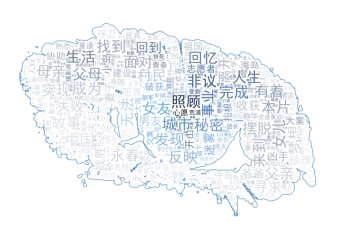

In [208]:
import wordcloud
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

path_font = '/content/drive/MyDrive/Github/Content/tools/articles/fonts/simhei.ttf'
path_mask_image = "/content/drive/MyDrive/Github/Content/tools/articles/img/m2.png"
path_color_image = "/content/drive/MyDrive/Github/Content/tools/articles/img/machine-1776925.jpg"
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'

# Extract Keywords from each summary
ls_kw = []
for s in df_view['梗概'].to_numpy():
  ls_kw.extend(textrank(s, topK=20))

# Append Title
ls_kw.extend(df_view['片名'].tolist())

# Append old title if diiferent from current title
ls_kw.extend([s for s in df_view['匹配片名'].tolist() if s!= ''])

#wordcloud.color_from_image(coloring)
mask = np.array(Image.open(path_mask_image)) # 定义词频背景

wc = wordcloud.WordCloud(
    font_path=path_font,
    width = 400,
    height = 100,
    scale = 1,
    mask=mask, # set back ground mask image
    max_words=444,
    max_font_size=88,
    #background_color="white", 
    background_color="rgba(255, 255, 255, 0)", 
    #mode="RGBA",
    mode="RGB",
    contour_width=3, 
    contour_color='steelblue',
    repeat=True,
    #color_func=image_colors,
)
wc.generate(','.join(ls_kw))

coloring = np.array(Image.open(path_color_image)) # Load Image for coloring
#image_colors = wordcloud.ImageColorGenerator(mask, default_color=(79, 46, 47))
image_colors = wordcloud.ImageColorGenerator(coloring)
wc.recolor(color_func=image_colors,  random_state=3)

plt.imshow(wc) # 显示词云
plt.axis('off') # 关闭坐标轴
plt.show()

wc.to_file(path_img + '/ChinaFilm_NewReleases_Overview_' + str_date_curr_release + '.png')


##[4.3] 最年长

In [209]:
P2 = '\t'
P2 += '怀胎最久的影片是《{}》,'.format(df_view.iloc[0]['片名'])
P2 += '从备案到获得公映证超过{}年，'.format(df_view.iloc[0]['备案至今'].lstrip('> ').rstrip(' 年'))
P2 += '名字从《{}》进化成了《{}》，'.format(df_view.iloc[0]['匹配片名'], df_view.iloc[0]['片名'])
P2 += '第一出品方历经了{},最终由{}接棒。'.format(df_view.iloc[0]['原备案单位'], df_view.iloc[0]['第一出品单位'])
P2 += '制片方的坚持呼应着电影中主人公的坚持："{}"。'.format("他们一次次想放弃，却又一次次坚守…成为了真正的守岛英雄")

ls_choices = ['美好', '胜利', '牛逼']
P2 += '坚持就是{}。'.format(ls_choices[random.randint(0,len(ls_choices)-1)])

print(P2)

	怀胎最久的影片是《守岛人》,从备案到获得公映证超过6.7年，名字从《两个人的海岛》进化成了《守岛人》，第一出品方历经了南京杰纳德影视文化传媒有限责任公司、江苏新希望农村数字电影院线有限公司,最终由八一电影制片厂接棒。制片方的坚持呼应着电影中主人公的坚持："他们一次次想放弃，却又一次次坚守…成为了真正的守岛英雄"。坚持就是美好。


In [210]:
df_view.loc[df_view['第一出品单位'] == '北京拉近影业有限公司', '片名']

31    射雕英雄传之降龙十八掌
9     射雕英雄传之九阴白骨瓜
Name: 片名, dtype: object

## [4.4] 同样坚守的还有...

In [211]:
ls_name_4plus_year = df_view.loc[df_view['备案至今'].apply(lambda x: float(x.lstrip('> ').rstrip(' 年')))>4, '片名'].tolist()[1:]
ls_name_4plus_year = ['《'+ name + '》' for name in ls_name_4plus_year]
P3 = "\t"
P3 += '同样坚守了超过4年的影片还有{}等。'.format('、'.join(ls_name_4plus_year))

P3 += '其中,{}同时推出了《{}》和《{}》。'.format('北京拉近影业', 
                                    df_view.loc[df_view['第一出品单位'] == '北京拉近影业有限公司', '片名'][31],
                                    df_view.loc[df_view['第一出品单位'] == '北京拉近影业有限公司', '片名'][9]
                                    )

P3 += '一个小笔误梅姐姐的白骨爪变成了白骨瓜，又啃爪子又吃瓜，太顽皮了。'
P3 += '影片《超越》是个进度控，原名叫做《急速超越》，出品方从小猎豹长大成了青年猎豹，想来是还没成为老猎豹，小小超越就好了，不用急速了。'
print(P3)

	同样坚守了超过4年的影片还有《阳光姐妹淘》、《多乐路》、《射雕英雄传之降龙十八掌》等。其中,北京拉近影业同时推出了《射雕英雄传之降龙十八掌》和《射雕英雄传之九阴白骨瓜》。一个小笔误梅姐姐的白骨爪变成了白骨瓜，又啃爪子又吃瓜，太顽皮了。影片《超越》是个进度控，原名叫做《急速超越》，出品方从小猎豹长大成了青年猎豹，想来是还没成为老猎豹，小小超越就好了，不用急速了。


In [212]:
df_view['梗概'].iloc[0]

'民兵王建国夫妇前往环境恶劣的开山岛做守卫祖国海岛的志愿者。在与台风和走私犯斗智斗勇中，他们一次次想放弃，却又一次次坚守。面对非议，夫妇决定扎根建设小岛，并协助破获了犯罪大案，成为了真正的守岛英雄……'

## [4.5] 指向电影官网

In [213]:
#####
E1 = '\n\n'
E1 += '\t'
E1 += '慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。'
E1 += '公映许可证公示信息来自中国国家电影局 China Film Administration, 官方网址 '
E1 += ' http://www.chinafilm.gov.cn/chinafilm 。'

print(E1)



	慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。公映许可证公示信息来自中国国家电影局 China Film Administration, 官方网址  http://www.chinafilm.gov.cn/chinafilm 。


In [214]:
 df_view['片名'].to_numpy()[0:5]

array(['守岛人', '阳光姐妹淘', '多乐路', '射雕英雄传之降龙十八掌', '丑角'], dtype=object)

## [4.6] 生成摘要

In [215]:
S0 = '{}月新片{}部，'.format(dt_curr_release.month, df_curr_releases.shape[0])
S0 += '平均孕期超{}年，'.format(round(df_view['备案至今'].apply(lambda x: float(x.lstrip('> ').rstrip(' 年'))).mean(),1))
S0 += '改名的{}部，'.format(df.loc[df_view['匹配片名'] == '',:].shape[0])
S0 += '换主的{}部，'.format(df.loc[df_view['原备案单位'] == '',:].shape[0])
S0 += '瓜熟落地求观赏：'
ls_oldest5 = ['《'+ name + '》' for name in df_view['片名'].to_numpy()[0:5]]
S0 += '{}'.format('、'.join(ls_oldest5))
S0 += '…'

print(S0)

6月新片31部，平均孕期超2.6年，改名的18部，换主的18部，瓜熟落地求观赏：《守岛人》、《阳光姐妹淘》、《多乐路》、《射雕英雄传之降龙十八掌》、《丑角》…


# [5] Output Word Doc

## [5.1] Install Docx Lib

In [216]:
!pip install python-docx
!pip install lxml
from docx import Document
from docx.shared import Inches
#from docx.text.parargaph import Paragraph

from docx.shared import Pt

In [217]:
df_view

,片名,匹配片名,梗概,备案至今,是否修改,第一出品单位,原备案单位,编剧
21,守岛人,两个人的海岛,民兵王建国夫妇前往环境恶劣的开山岛做守卫祖国海岛的志愿者。在与台风和走私犯斗智斗勇中，他们一...,> 6.7 年,,八一电影制片厂,南京杰纳德影视文化传媒有限责任公司、江苏新希望农村数字电影院线有限公司,林叶
30,阳光姐妹淘,,曾经是中学sunny小团体成员，25年后为人妇为人母的美君，偶然重逢了当年的挚友静华，为帮身...,> 4.7 年,,上海喜焰文化发展有限公司,天津逗友文化传播有限公司,雷婷
23,多乐路,,一场交通事故令木森、大海、平安和一对情侣有了交集。在这平行时空中，每个人的人生千差万别、欢喜哀怨。,> 4.5 年,,美亚长城传媒（北京）有限公司,,杨龙澄
31,射雕英雄传之降龙十八掌,射雕英雄传,蒙古荒漠，牧羊童听见杀声四起，发现铁木真军队大战泰亦赤兀部军，铁木真用兵如神，拚死之下彻底击...,> 4.4 年,,北京拉近影业有限公司,中影寰亚音像制品有限公司、寰亚电影制作有限公司,陈嘉上、谭广源
22,丑角,,一个女子投靠到乡间剧团，受到团长精心照顾，并渐渐在乡间走红。出于感激和依赖，与团长走在一起。...,> 4.0 年,,北京活动影像国际广告有限公司,,谷东
6,越界,,摄影师志成有着一个多年的秘密，从18岁起，他时常觉得被“跟踪”，在目睹了一场意外后，他更确信...,> 3.8 年,,深圳市乐享影业有限公司,,梁鸿华、叶乔
24,等儿的湿地,,姥姥去世了，晓涵来到姥姥当知青下乡时的三江湿地，意外发现姥姥留下的明信片，得知东方白鹳“等儿...,> 3.8 年,,北京知梦文化影视传媒有限公司,,三牛
27,山里山外,山外,本片由武义县下山脱贫事迹改编片中反映了高山人民面对恶劣生存条件，百折不挠的精神。讴歌了共产党...,> 3.7 年,,武义舜熙影业有限公司,,孙昌文
3,永春拳之黄金蝴蝶刀,永春,三十年代初，黑龙帮盘踞在广东顺德码头，无恶不作，使得民生载道。永春堂为民除害，却被奸人报复，...,> 3.5 年,,广东镇宇影视传媒有限公司,,刘天舒
10,奇迹小子,,王汉坤为实现自己心中的梦想让花式摩托车极限运动走上国际赛场，对六岁的儿子王克进行残酷的魔鬼训...,> 3.2 年,,安徽天惟影视文化有限公司,,潘富荣


## Write to docx

In [226]:
path_doc = '/content/drive/MyDrive/Github/Content/tools/articles/docx'
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'

doc = Document()
doc.core_properties.title = 'ChinaFilm_NewReleases_Overview_' + str_date_curr_release
style = doc.styles['Normal']
font = style.font
font.name = 'simhei'
font.size = Pt(12)

doc.add_heading(T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(P1)

doc.add_picture(path_img + '/posters/' + '守岛人_h.jpg', width =Inches(3))

doc.add_paragraph(P2)
doc.add_paragraph(P3)

doc.add_picture(path_img + '/ChinaFilm_NewReleases_Overview_' + str_date_curr_release + '.png', width =Inches(3))

table = doc.add_table(rows=1, cols=1, style='Light List Accent 4')
i = 1
for _, row in df_view.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[' + str(i) + ']' + '《'.format(i) + row['片名'] + '》'
  if row['匹配片名'] != '':
    row_cells[0].text += ' (原备案名《{}》)'.format(row['匹配片名'])

  row_cells = table.add_row().cells
  row_cells[0].text = '编剧: ' + row['编剧'] 
  
  row_cells = table.add_row().cells
  row_cells[0].text = '距离备案 ' + row['备案至今']
  if row['是否修改'] == '是':
    row_cells[0].text += ', 修改后通过备案'

  row_cells = table.add_row().cells
  row_cells[0].text = '第一出品单位: ' + row['第一出品单位']
  if row['原备案单位'] != '': 
    row_cells = table.add_row().cells
    row_cells[0].text = '原备案单位：{}）'.format(row['原备案单位'])

  row_cells = table.add_row().cells
  row_cells[0].text = row['梗概'].lstrip('\w+')

  row_cells = table.add_row().cells
  row_cells[0].text = ''
  i+=1


doc.add_paragraph(E1)

doc.save(path_doc + '/ChinaFilm_NewReleases_Overview_' + str_date_curr_release +'.docx' )